In [39]:
# import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
from datasets.image_dataset import ImageDataset, UniformImageDataset
from tqdm import tqdm
from matplotlib import rc

# latex text in plots
usetex = True
if usetex:
    rc('text', usetex=True)

#change plt parameter globally 
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16})

In [40]:
# load csv files
train_image_csv = pd.read_csv("data/train_image_level.csv")
train_study_csv = pd.read_csv("data/train_study_level.csv")

# Bounding Boxes

## Number of Bounding Boxes

In [41]:
nr_bounding_boxes = np.zeros(len(train_image_csv), dtype=int)
for index in range(len(train_image_csv)):
    row = train_image_csv.iloc[index]
    if isinstance(row["boxes"], float):
        nr_bounding_boxes[index] = 0
    elif isinstance(row["boxes"], str):
        boxes = json.loads(row["boxes"].replace("'", '"'))
        nr_bounding_boxes[index] = len(boxes)
    else:
        raise TypeError("unexpected type of 'boxes':", type(meta["boxes"]))

In [42]:
"""
nums_bb = np.bincount(nr_bounding_boxes)
plt.bar(np.arange(np.max(nr_bounding_boxes)+1), nums_bb, width=1)
plt.yscale("log")
plt.xticks(np.arange(np.max(nr_bounding_boxes)+1))
plt.show()
""";

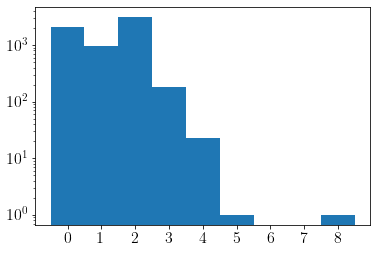

In [43]:
plt.hist(nr_bounding_boxes, range=(-0.5,8.5), bins=int(np.max(nr_bounding_boxes))+1)
plt.yscale("log")
plt.xticks(range(9))
#plt.title("Number of Bounding Boxes per Image")
plt.savefig("images/bounding_box_numbers_per_image.pdf", bbox_inches='tight')
plt.show()

## Images with or without Bounding Boxes

In [44]:
bounding_box_images = np.array(train_image_csv["boxes"].notna())
total_images = len(bounding_box_images)
nr_bounding_box_images = np.sum(bounding_box_images)

In [45]:
if not os.path.isdir("images"):
    os.makedirs("images")

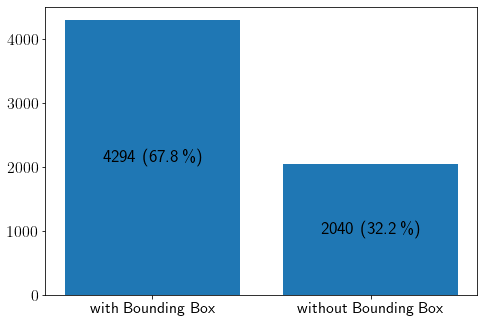

In [63]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['with Bounding Box', 'without Bounding Box']
numbers = [nr_bounding_box_images, total_images - nr_bounding_box_images]
ax.bar(labels, numbers)
#plt.title("Number of Images")
if usetex:
    for index, number in enumerate(numbers):
        plt.text(x=index,y=number/2,s="{} ({:.1f}\,\%)".format(number, 100*number/total_images), horizontalalignment="center", verticalalignment="center")
else:
    for index, number in enumerate(numbers):
        plt.text(x=index,y=number/2,s="{} ({:.1f}%)".format(number, 100*number/total_images), horizontalalignment="center", verticalalignment="center")
plt.savefig("images/bounding_box_barchart.pdf", bbox_inches='tight')
plt.show()

In [64]:
def make_autopct(values, usetex):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if usetex:
            return """{p:.1f}\,\%
({v:d})""".format(p=pct,v=val)
        else:
            return """{p:.1f}%
({v:d})""".format(p=pct,v=val)
    return my_autopct

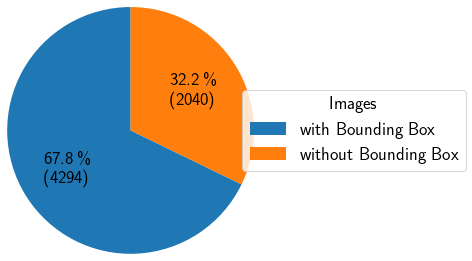

In [65]:
wedges, texts, autotexts = plt.pie(numbers, startangle=90, autopct=make_autopct(numbers, usetex), radius = 1.5)
plt.legend(wedges, labels, title="Images", loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.savefig("images/bounding_box_piechart.pdf", bbox_inches='tight')
plt.show()

# Studies Label

In [66]:
total_studies = len(train_study_csv)
nr_negativ_pneumonia = np.sum(train_study_csv["Negative for Pneumonia"])
nr_typical_pneumonia = np.sum(train_study_csv["Typical Appearance"])
nr_indeterminate_pneumonia = np.sum(train_study_csv["Indeterminate Appearance"])
nr_atypical_pneumonia = np.sum(train_study_csv["Atypical Appearance"])
pneumonia_numbers = np.array([nr_negativ_pneumonia, nr_typical_pneumonia, nr_indeterminate_pneumonia,
                              nr_atypical_pneumonia])
pneumonia_labels = ["No Pneumonia", "Typical Pneumonia", "Intdeterminate Pneumonia", "Atypical Pneumonia"]
assert total_studies == np.sum(pneumonia_numbers)

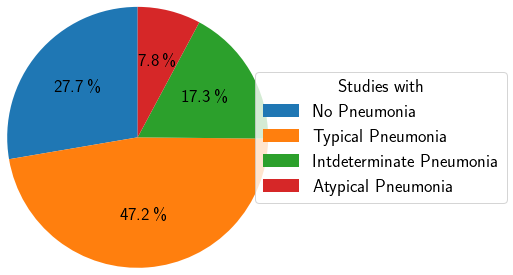

In [88]:
"""plt.pie(pneumonia_numbers, labels = pneumonia_labels, startangle=90)
plt.savefig("images/bounding_box_piechart.pdf")
plt.show()"""
if usetex:
    autopct = "%.1f\,\%%"
else:
    autopct = "%.1f%%"
p_wedges, _, _ = plt.pie(pneumonia_numbers, autopct=autopct, startangle=90,radius = 1.5)
plt.legend(p_wedges, pneumonia_labels, title="Studies with", loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig("images/bounding_box_piechart.pdf", bbox_inches='tight')
plt.show()

# Gender Plot and Size of the Images

In [68]:
imagedataset = ImageDataset("data/train", "data/train_image_level.csv")
#dataset = UniformImageDataset(imagedataset)

In [69]:
if os.path.exists("images/sizes.npy") and os.path.exists("images/genders.npy"):
    sizes = np.load("images/sizes.npy")
    genders = np.load("images/genders.npy")
else:
    sizes = np.zeros((2,len(imagedataset)), dtype=int)
    genders = np.zeros(len(imagedataset), dtype=str)

    for i in tqdm(range(len(imagedataset))):
        dicom, _ = imagedataset[i]
        sizes[:,i] = dicom.pixel_array.shape
        genders[i] = dicom.PatientSex

    np.save("images/sizes.npy", sizes)
    np.save("images/genders.npy", genders)  

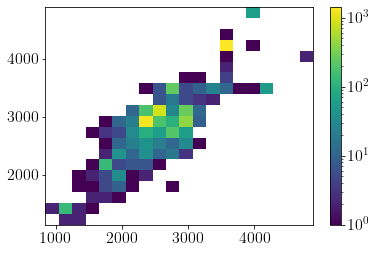

In [71]:
plt.hist2d(sizes[0], sizes[1], bins=20, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.savefig("images/hist2d_image_sizes.pdf", bbox_inches='tight')
plt.show()

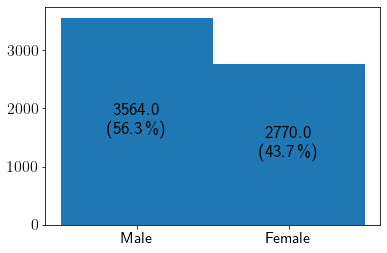

In [87]:
gender_nums = plt.hist(genders, bins=2)
#plt.title("Patient Sex")
plt.xticks([0.25, 0.75], ["Male", "Female"])
if usetex:
    for index, gender in enumerate(gender_nums[0]):
        plt.text(x=index*0.5+0.25, y=gender/2, s="""{}
({:.1f}\,\%)""".format(gender, 100*gender/np.sum(gender_nums[0])), horizontalalignment="center", verticalalignment="center")
else:
    for index, gender in enumerate(gender_nums[0]):
        plt.text(x=index*0.5+0.25, y=gender/2, s="""{}
({:.1f}%)""".format(gender, 100*gender/np.sum(gender_nums[0])), horizontalalignment="center", verticalalignment="center")
plt.savefig("images/gender_occurence.pdf", bbox_inches='tight')
plt.show()

# Pixel Value Histogram

In [74]:
if os.path.exists("images/pixel_value_stats.npy"):
    pixel_value_stats = np.load("images/pixel_value_stats.npy")
else:
    # pixel_value_stats[0]: minimal pixel value
    # pixel_value_stats[1]: maximal pixel value
    # pixel_value_stats[2]: mean pixel value
    pixel_value_stats = np.zeros((3,len(imagedataset)))
    for i in tqdm(range(len(imagedataset))):
        dicom, _ = imagedataset[i]
        image = dicom.pixel_array
        pixel_value_stats[0,i] = np.min(image)
        pixel_value_stats[1,i] = np.max(image)
        pixel_value_stats[2,i] = np.mean(image)
    np.save("images/pixel_value_stats.npy", pixel_value_stats)

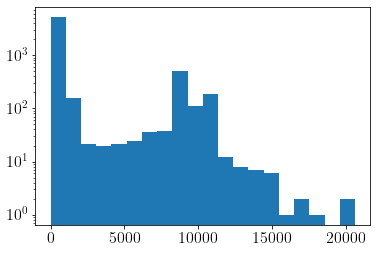

In [82]:
plt.hist(pixel_value_stats[0],bins=20)
plt.yscale("log")
#plt.title("Distribution of Minimum Values")
plt.savefig("images/distri_min_vals.pdf", bbox_inches='tight')
plt.show()

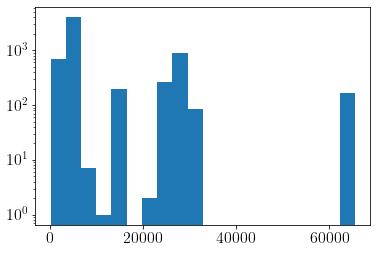

In [85]:
plt.hist(pixel_value_stats[1], bins=20)
plt.yscale("log")
#plt.title("Distribution of Maximum Values")
plt.savefig("images/distri_max_vals.pdf", bbox_inches='tight')
plt.show()

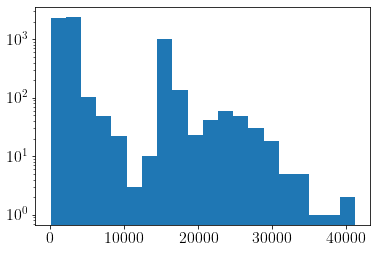

In [84]:
plt.hist(pixel_value_stats[2], bins=20)
plt.yscale("log")
#plt.title("Distribution of Mean Values")
plt.savefig("images/distri_mean_vals.pdf", bbox_inches='tight')
plt.show()